**Auteur**: Voahangy Joan Aléonard<br>
**Dernière mise à jour** : 15 juillet 2021

# <font color=red>**Analyse Exploratoire du jeu de Données News Portal par Globo.com**</font>

# <font color=green>**Jeux de données**</font>

---
Dans ce notebook, nous allons étudié le jeu de données **[News Portal - by Globo.com](https://www.kaggle.com/gspmoreira/news-portal-user-interactions-by-globocom#clicks_sample.csv)**, afin de l'utiliser comme base pour de la **recommandation de contenu à des lecteurs**.

Il fournit notamment :
- Le dossier **clicks**, qui contient des fichiers .CSV répertoriant les interactions des utilisateurs sur le portail Globo.com (un fichier par heure);
- Le fichier .CSV **articles_metadata**, qui contient des informations sur les métadonnées de tous les articles publiés (364.047) ;
- Le fichier **articles_embeddings.pickle** contenant les Embeddings des articles (vecteurs de dimensions 250), entraînés sur le texte et les métadonnées des articles via [CHAMELEON (pour aller plus loin)](https://github.com/gabrielspmoreira/chameleon_recsys).

## <font color=blue>**Import des librairies**</font>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import os
import pickle
from time import time
from random import randint
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Set general configurations
src_path = Path('/content/drive/MyDrive/OC_IA/P09/data')
click_path = Path('/content/drive/MyDrive/OC_IA/P09/data/clicks')

## <font color=blue>**Chargement des données**</font>

### **Les données de clics**

---

Nous chargeons tous les fichiers du dossier **clicks** pour avoir une vue globale sur les données disponibles.

Sur le lien Kaggle, nous avons:
- <code>user_id</code> : l'identifiant unique de l'utilisateur
- <code>session_id</code> : l'identifiant unique de la session; dans une session, un utilisateur peut avoir consulté plusieurs articles ;
- <code>session_start</code> : le timestamp de la 1ère interaction de la session ;
- <code>session_size</code> : le nombre d'interaction durant la session ;
- <code>click_article_id</code> : l'article consulté par l'utilisateur (1 ou plus) ;
- <code>click_timestamp</code> : le timestamp de l'interaction ;
- <code>click_environment</code> : l'identifiant de l'environnement (1-Facebook, 2-Appli mobile 3-Pages mobiles 4- Web) ;
- <code>click_deviceGroup</code> : le type de terminal utilisé (1-tablette, 2-TV, 4-Mobile, 5-Ordinateur, ou 3-vide) ;
- <code>click_os</code> : l'identifiant du système d'exploitation (1-Other, 2-iOS, 3-Android, 4-Windows Phone, 5-Windows Mobile, 6-Windows, 7-Mac OS X, 8-Mac OS, 9-Samsung, 10-FireHbbTV, 11-ATV OS X, 12-tvOS, 13-Chrome OS, 14-Debian, 15-Symbian OS, 16-BlackBerry OS, 17-Firefox OS, 18-Android, 19-Brew MP, 20-Chromecast, 21-webOS, 22-Gentoo, 23-Solaris) ;
- <code>click_country</code> : l'identifiant du pays ;
- <code>click_region</code> : la région ;
- <code>click_referrer_type</code> : (Pas d'information).

In [3]:
# Create filename list and empty list
click_filelist = sorted(os.listdir(click_path))
click_list = []

# Iterate over files in folder and list
for i in range(0, len(click_filelist)):
    # Read CSV file (i order)
    temp = pd.read_csv(click_path / click_filelist[i])
    # Create a specific column to track the file number
    temp['filename'] = i
    # Append to list
    click_list.append(temp)

# Concate in unique DF
clicks = pd.concat(click_list, axis=0, ignore_index=True)

# Rename columns
clicks.rename(columns={'click_article_id':'article_id'}, inplace=True)

# Convert date string to datetime
date2convert = ['session_start', 'click_timestamp']
for col in date2convert:
    clicks[col] = pd.to_datetime(clicks[col], unit='ms')

# Display shape and 5 first rows
print('Données de clics: ', clicks.shape)
clicks.head()

Données de clics:  (2988181, 13)


,user_id,session_id,session_start,session_size,article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,filename
0,0,1506825423271737,2017-10-01 02:37:03,2,157541,2017-10-01 03:00:28.020,4,3,20,1,20,2,0
1,0,1506825423271737,2017-10-01 02:37:03,2,68866,2017-10-01 03:00:58.020,4,3,20,1,20,2,0
2,1,1506825426267738,2017-10-01 02:37:06,2,235840,2017-10-01 03:03:37.951,4,1,17,1,16,2,0
3,1,1506825426267738,2017-10-01 02:37:06,2,96663,2017-10-01 03:04:07.951,4,1,17,1,16,2,0
4,2,1506825435299739,2017-10-01 02:37:15,2,119592,2017-10-01 03:04:50.575,4,1,17,1,24,2,0


In [4]:
# Check unique values per column
print('=== Valeurs uniques des features de la table des interactions ===')
print('=================================================================')
for col in clicks.columns:
    print(col, ' :', clicks[col].nunique())

=== Valeurs uniques des features de la table des interactions ===
user_id  : 322897
session_id  : 1048594
session_start  : 646874
session_size  : 72
article_id  : 46033
click_timestamp  : 2983198
click_environment  : 3
click_deviceGroup  : 5
click_os  : 8
click_country  : 11
click_region  : 28
click_referrer_type  : 7
filename  : 384


**NOTE**:
- Information sociale : environment, device group & os ;
- Information géographique : country, région.

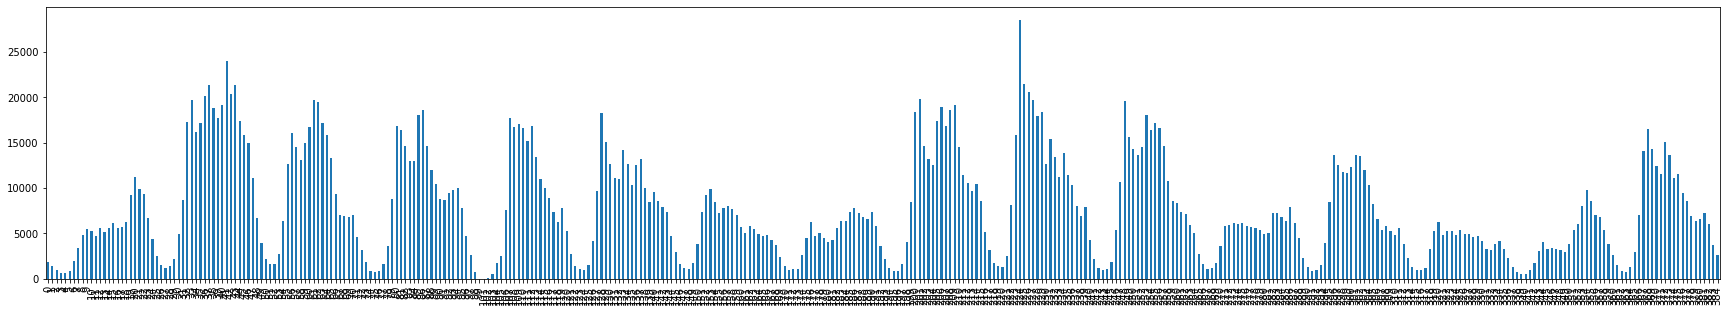

In [5]:
# Plot file size per filename
clicks.filename.value_counts().sort_index(ascending=True).plot(kind='bar', figsize=(30,5))

**NOTE**: le fichier N°100 ne contient pas de données.

### **Les métadonnées des articles**

---

Le fichier CSV contient les données suivantes:
- <code>article_id</code> : l'identifiant de l'article ;
- <code>category_id</code> : l'identifiant de la catégorie de l'article ;
- <code>created_at_ts</code> : la date de publication de l'article ;
- <code>publisher_id</code> : l'identifiant de l'éditeur de l'article ;
- <code>word_count</code> : le nombre de mots par article.

In [6]:
# Read CSV data, print shape and display 5 first rows
articles = pd.read_csv(src_path / 'articles_metadata.csv')

# Convert date string to datetime type
articles['created_at_ts'] = pd.to_datetime(
    (pd.to_datetime(
        articles['created_at_ts'],
        unit='ms')).dt.strftime('%Y/%m/%d'))
print('Min/Max creation date:', articles['created_at_ts'].min(),
      '/ ', articles['created_at_ts'].max())

# Display shape and 5 first rows
print('Métadonnées des articles: ', articles.shape)
articles.head()

Min/Max creation date: 2006-09-27 00:00:00 /  2018-03-13 00:00:00
Métadonnées des articles:  (364047, 5)


,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,2017-12-13,0,168
1,1,1,2014-07-14,0,189
2,2,1,2014-08-22,0,250
3,3,1,2014-08-19,0,230
4,4,1,2014-08-03,0,162


In [7]:
# Check unique values per column
print('=== Valeurs uniques des features de la table des articles ===')
print('=============================================================')
for col in articles.columns:
    print(col, ' :', articles[col].nunique())

=== Valeurs uniques des features de la table des articles ===
article_id  : 364047
category_id  : 461
created_at_ts  : 2302
publisher_id  : 1
words_count  : 866


### **Les embeddings des articles**

---

Pour rappel, la matrice d'embeddings est un vecteur de 250 dimensions, représentant généralement le poids des mots du vocabulaire utilisés dans un document - ici, les articles.

In [8]:
# Load pickle data
with open(src_path / 'articles_embeddings.pickle', 'rb') as file:
    embeddings = pickle.load(file)

# Save as dataframe
df_embeddings = pd.DataFrame(embeddings)
df_embeddings = df_embeddings.add_prefix('dim_')

# Display shape and 5 first rows
print('Embeddings des articles: ', df_embeddings.shape)
df_embeddings.head()

Embeddings des articles:  (364047, 250)


,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,dim_10,dim_11,dim_12,dim_13,dim_14,dim_15,dim_16,dim_17,dim_18,dim_19,dim_20,dim_21,dim_22,dim_23,dim_24,dim_25,dim_26,dim_27,dim_28,dim_29,dim_30,dim_31,dim_32,dim_33,dim_34,dim_35,dim_36,dim_37,dim_38,dim_39,...,dim_210,dim_211,dim_212,dim_213,dim_214,dim_215,dim_216,dim_217,dim_218,dim_219,dim_220,dim_221,dim_222,dim_223,dim_224,dim_225,dim_226,dim_227,dim_228,dim_229,dim_230,dim_231,dim_232,dim_233,dim_234,dim_235,dim_236,dim_237,dim_238,dim_239,dim_240,dim_241,dim_242,dim_243,dim_244,dim_245,dim_246,dim_247,dim_248,dim_249
0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,-0.559561,-0.500603,0.165183,0.428434,0.355056,0.874437,-0.528883,0.625487,0.268920,-0.822835,-0.703853,-0.625845,-0.152855,-0.666241,0.043295,0.178638,0.046890,0.594531,-0.183348,0.195107,-0.467640,-0.304807,0.353175,0.278188,0.538623,-0.371209,0.489898,-0.103833,0.119174,0.132437,-0.621084,-0.453311,0.346627,...,0.764381,0.275644,-0.692138,-0.393240,-0.325693,0.163377,-0.154952,-0.701639,0.711825,-0.839063,-0.459145,0.919913,0.621834,-0.640471,0.389934,0.764178,0.164851,-0.747023,0.411034,0.750901,0.860643,0.614755,0.549660,0.334437,-0.388059,-0.703730,-0.567420,0.006478,-0.206590,-0.385272,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,-0.897996,-0.359747,0.398246,0.672840,-0.011180,-0.347506,-0.541346,0.458492,0.482316,0.713665,-0.474050,0.405787,0.671431,-0.480856,0.434779,0.468499,0.376424,0.368048,0.192545,0.095572,-0.542234,0.065547,0.363267,-0.162804,0.319617,0.469473,0.578466,-0.803637,-0.304545,0.635511,0.089978,-0.569946,0.102307,...,0.344321,-0.534050,0.728764,0.860110,-0.028166,0.491114,0.531556,0.545350,-0.241544,-0.091119,0.001625,0.950923,-0.367805,-0.215411,-0.131891,0.709081,0.612876,0.814885,0.278680,0.003690,-0.286773,-0.100936,-0.382605,-0.191886,-0.416420,-0.856593,0.537442,0.281693,-0.681829,0.666095,-0.487843,0.823124,0.412688,-0.338654,0.320787,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,-0.066126,-0.754899,-0.242004,0.670484,-0.280388,-0.557285,-0.084145,0.027782,0.294074,0.362697,-0.368549,0.147960,-0.011751,0.030209,0.106317,0.628013,0.388849,0.615911,-0.445113,0.106028,0.137109,-0.095536,0.342532,0.592646,-0.261791,0.342123,0.704539,-0.433067,0.104154,0.785971,0.588640,-0.627687,-0.143294,...,-0.600840,-0.539323,0.418196,0.028715,0.135008,-0.313483,0.744361,-0.145113,-0.485484,-0.591555,0.030112,0.952736,-0.569376,-0.359680,0.561676,0.381671,-0.189300,0.420950,0.022337,-0.329559,0.232765,0.424368,-0.484598,0.394343,-0.329527,-0.852293,0.634992,-0.532673,-0.469396,0.714991,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,-0.110514,0.591640,-0.245205,-0.788418,-0.345293,-0.756407,0.141115,0.283783,-0.369959,0.374733,0.922633,0.172219,0.253582,0.552108,-0.454131,0.385160,-0.151101,0.598559,-0.614190,-0.258765,0.591907,0.618749,0.414598,0.698184,-0.114862,-0.069056,-0.420455,0.589368,0.496948,-0.449707,-0.747113,...,-0.137121,-0.245490,0.170559,0.568089,-0.252295,-0.455726,0.756765,0.626615,-0.005399,-0.472355,0.324625,0.954345,-0.840553,-0.800332,0.111637,-0.501806,0.115986,0.805840,-0.041481,0.320630,-0.450113,-0.378700,0.509616,0.142787,0.149670,-0.896181,0.234389,-0.189831,-0.597612,0.263807,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,0.341194,-0.600554,-0.125644,0.698668,0.467503,-0.740664,-0.258062,-0.094110,0.256941,0.582071,-0.025041,0.339164,-0.348473,0.413076,0.159945,0.511137,0.608007,0.626225,-0.540690,0.623640,-0.019697,0.027607,-0.236370,0.311671,-0.559831,0.766381,0.412553,-0.663338,0.154626,0.708132,0.2

***Observations***:
- **322.897 utilisateurs** uniques ;
- **364.047 articles** disponibles dans la base, mais seulement **46.033** font l'object d'interactions avec les utilisateurs ;
- Près de **3 millions de clics** d'articles sur la période étudiés.

# <font color=green>**Recherche des informations essentielles**</font>

---

Comme le système de recommandation a pour objectif de proposer aux utilisateurs des articles qu'ils pourraient consulter, on peut considérer que les **acteurs principaux** du système sont les **utilisateurs** et les **articles**.

## <font color=blue>**Période d'analyse**</font>

In [9]:
# Print information
print('Les début et fin de session s\'étendent du {} au {}'.format(clicks.session_start.min(), clicks.session_start.max()))

Les début et fin de session s'étendent du 2017-10-01 02:37:03 au 2017-10-17 03:36:19


In [10]:
# Print information
print('La période de clics s\'étend du {} au {}'.format(clicks.click_timestamp.min(), clicks.click_timestamp.max()))

La période de clics s'étend du 2017-10-01 03:00:00.026000 au 2017-11-13 20:04:14.886000


***Observations:***
- Les sessions commencent le 1er octobre 2017 et se terminent le 17 octobre 2017, soit une période de 16 jours ;
- Les durées des sessions s'étendent du 1er octobre 2017 au 13 novembre 2017.

Ces 2 données semblent un peu **incohérentes**, mais les dates de démarrage de session devraient être plus fiables.

## <font color=blue>**Durée de consultation des articles**</font>

In [11]:
# Filter DF on necessary features
df0 = clicks[['user_id', 'session_id', 'session_start', 'click_timestamp']]

# Calculate the difference to previous row on timestamp
df1 = pd.DataFrame(
    df0.groupby(['user_id','session_id', 'session_start'],
                as_index=False)['click_timestamp'].diff().fillna(pd.Timedelta(seconds=0)))

# Rename column
df1.rename(columns={'click_timestamp':'delta_w_previous'}, inplace=True)

# Join result with previous df
views = df0.join(df1)

# Create new feature with timestamp difference
views['end_article_view'] = views['click_timestamp'] - views['session_start']

# Create new feature by applying conditions and converting timestamp to seconds
views['view_duration'] = np.where(round(views['delta_w_previous'].dt.total_seconds(),0) == 0,
                             round(views['end_article_view'].dt.total_seconds(), 0),
                             round(views['delta_w_previous'].dt.total_seconds(), 0))

# Display 5 first rows
views.head()

,user_id,session_id,session_start,click_timestamp,delta_w_previous,end_article_view,view_duration
0,0,1506825423271737,2017-10-01 02:37:03,2017-10-01 03:00:28.020,0 days 00:00:00,0 days 00:23:25.020000,1405.0
1,0,1506825423271737,2017-10-01 02:37:03,2017-10-01 03:00:58.020,0 days 00:00:30,0 days 00:23:55.020000,30.0
2,1,1506825426267738,2017-10-01 02:37:06,2017-10-01 03:03:37.951,0 days 00:00:00,0 days 00:26:31.951000,1592.0
3,1,1506825426267738,2017-10-01 02:37:06,2017-10-01 03:04:07.951,0 days 00:00:30,0 days 00:27:01.951000,30.0
4,2,1506825435299739,2017-10-01 02:37:15,2017-10-01 03:04:50.575,0 days 00:00:00,0 days 00:27:35.575000,1656.0


On va regarder plus en détail sur 2 utilisateurs :
- User n°68 ;
- User n°320431.

In [12]:
# Check 1 user
views[views.user_id == 68]

,user_id,session_id,session_start,click_timestamp,delta_w_previous,end_article_view,view_duration
180,68,1506826396181805,2017-10-01 02:53:16,2017-10-01 23:26:26.082,0 days 00:00:00,0 days 20:33:10.082000,73990.0
181,68,1506826396181805,2017-10-01 02:53:16,2017-10-01 23:30:31.121,0 days 00:04:05.039000,0 days 20:37:15.121000,245.0
182,68,1506826396181805,2017-10-01 02:53:16,2017-10-01 23:32:33.364,0 days 00:02:02.243000,0 days 20:39:17.364000,122.0
183,68,1506826396181805,2017-10-01 02:53:16,2017-10-03 02:35:24.157,1 days 03:02:50.793000,1 days 23:42:08.157000,97371.0
184,68,1506826396181805,2017-10-01 02:53:16,2017-10-03 02:35:54.157,0 days 00:00:30,1 days 23:42:38.157000,30.0
528189,68,1507040027288752,2017-10-03 14:13:47,2017-10-03 14:15:18.994,0 days 00:00:00,0 days 00:01:31.994000,92.0
528190,68,1507040027288752,2017-10-03 14:13:47,2017-10-05 01:04:38.792,1 days 10:49:19.798000,1 days 10:50:51.792000,125360.0
528191,68,1507040027288752,2017-10-03 14:13:47,2017-10-05 01:05:08.792,0 days 00:00:30,1 days 10:51:21.792000,30.0
2003920,68,1507664316334864,2017-10-10 19:38:36,2017-10-10 19:42:13.873,0 days 00:00:00,0 days 00:03:37.873000,218.0
2003921,68,1507664316334864,2017-10-10 19:38:36,2017-10-10 19:42:43.873,0 days 00:00:30,0 days 00:04:07.873000,30.0


In [13]:
# Check 1 user
views[views.user_id == 320431]

,user_id,session_id,session_start,click_timestamp,delta_w_previous,end_article_view,view_duration
2941940,320431,1508183187238264,2017-10-16 19:46:27,2017-10-17 11:50:50.064,0 days 00:00:00,0 days 16:04:23.064000,57863.0
2941941,320431,1508183187238264,2017-10-16 19:46:27,2017-10-23 11:46:15.555,5 days 23:55:25.491000,6 days 15:59:48.555000,518125.0
2941942,320431,1508183187238264,2017-10-16 19:46:27,2017-10-26 13:16:13.801,3 days 01:29:58.246000,9 days 17:29:46.801000,264598.0
2941943,320431,1508183187238264,2017-10-16 19:46:27,2017-10-27 12:30:42.714,0 days 23:14:28.913000,10 days 16:44:15.714000,83669.0
2941944,320431,1508183187238264,2017-10-16 19:46:27,2017-11-03 11:52:38.700,6 days 23:21:55.986000,17 days 16:06:11.700000,602516.0
2941945,320431,1508183187238264,2017-10-16 19:46:27,2017-11-03 19:17:54.249,0 days 07:25:15.549000,17 days 23:31:27.249000,26716.0
2941946,320431,1508183187238264,2017-10-16 19:46:27,2017-11-13 20:03:44.886,10 days 00:45:50.637000,28 days 00:17:17.886000,866751.0
2941947,320431,1508183187238264,2017-10-16 19:46:27,2017-11-13 20:04:14.886,0 days 00:00:30,28 days 00:17:47.886000,30.0


In [14]:
# views[views.article_id == 160974]

***Observations:***
- Nous constatons que nous ne pouvons utiliser cette information car toutes les dernières consultations d'articles par un client sur une session donnée sont limitées par défaut à 30s ;
- De même, certaines consultations durent plus longtemps que nécessaires, allant jusqu'à 10 jours pour certains.

***Conclusion:***<br>
Nous n'utiliserons pas ces données pour notre projet.

## <font color=blue>**Profilage de l'utilisateur**</font>

Pour identifier les articles qui peuvent intéresser l'utilisateur, nous devons analyser les données le concernant pour construire **un "ensemble de connaissances" explicitement ou implicitement représenté** afin d'établir son **profil** - profil qui sera ensuite exploité par le système de recommandation.

On dit des données qu'elles sont:
- <font color=blue>explicites</font>, lorsque l'utilisateur est impliqué dans la construction des données, par exemple, lorsqu'il donne une notation à un article, met un "like" sur un article, etc. ;
- <font color=blue>implicites</font>, lorsque les données capturées concernent les interactions de l'utilisateur avec le système, tel que l'historique de navigation ou de recherche, les clics sur les articles, les téléchargements, la durée de consultation, la plateforme utilisée, etc.

Dans cette partie, nous allons essayer de trouver les données exploitables concernant les utilisateurs.

### **Session**

# session per user, Mean: 3.2 - Min: 1, Max: 207.


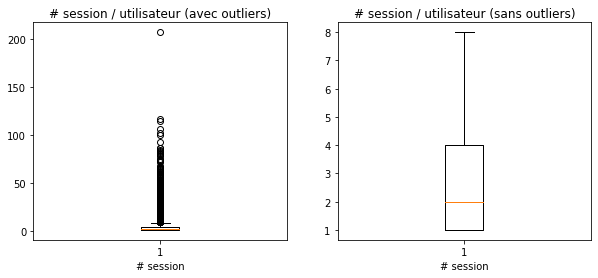

In [15]:
# Print information
x = clicks.groupby(['user_id'])['session_id'].nunique()
print(
    '# session per user, Mean: {} - Min: {}, Max: {}.'.format(round(x.mean(), 1),
                                                              x.min(),
                                                              x.max()))

# Plot boxplot
fig, (ax1, ax2) = plt.subplots (1, 2, figsize=(10, 4))
ax1.boxplot(x)
ax1.set_xlabel('# session')
ax1.set_title('# session / utilisateur (avec outliers)')
ax2.boxplot(x, showfliers=False)
ax2.set_xlabel('# session')
ax2.set_title('# session / utilisateur (sans outliers)')
plt.show()

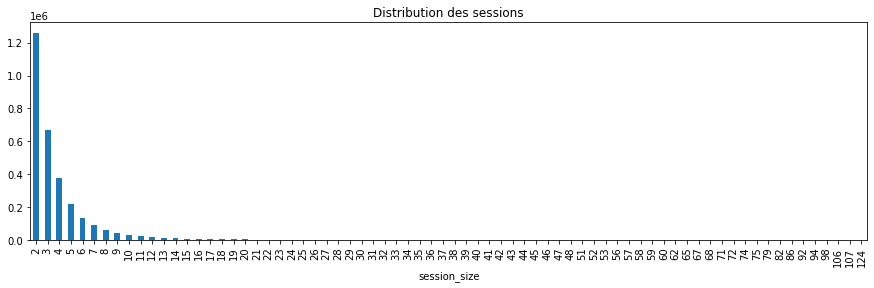

In [16]:
# Plot bar with groupby
clicks.groupby('session_size').size().plot(kind='bar', figsize=(15, 4),
                                           title='Distribution des sessions')

***Observations:***
- Les utilisateurs ont eu en moyenne 3 sessions sur la période d'analyse, avec un minimum à 1 et un maximum à 207.
- Les utilisateurs consultent en général 2 articles par session, avec un maximum à 124 ;

### **Localisation géographique**

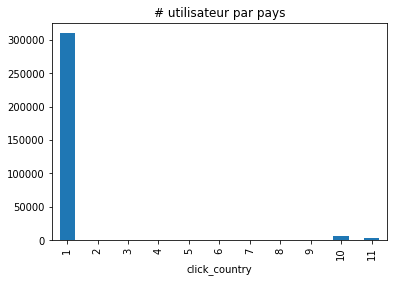

In [17]:
# Plot month_day distribution
clicks.groupby('click_country')['user_id'].nunique().plot(kind='bar', title='# utilisateur par pays')

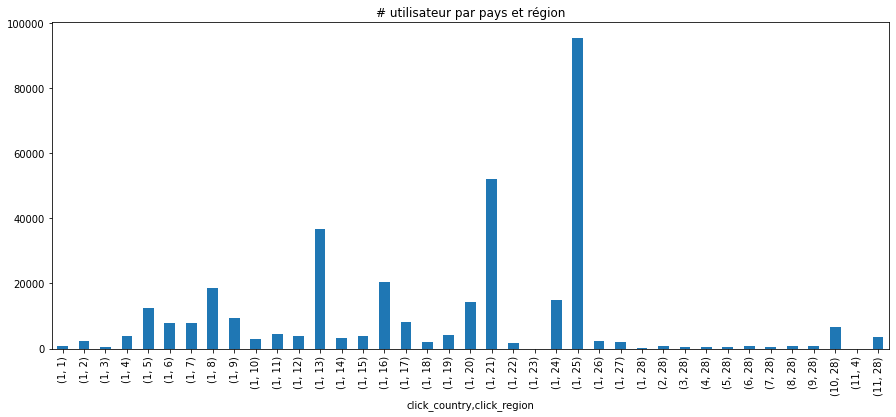

In [18]:
# Plot month_day distribution
clicks.groupby(['click_country', 'click_region'])['user_id'].nunique().plot(kind='bar', figsize=(15, 6), title='# utilisateur par pays et région')

***Observations:***
- La majorité des utilisateurs sont localisés dans le pays n°1 ;
- Dans le pays n°1, les 3 régions les plus actives par ordre d'importance sont 25, 21 et 13.

**NOTE**: ces données pourraient éventuellement être utilisées dans un système de recommandation hybride.

### **Période de consultation**

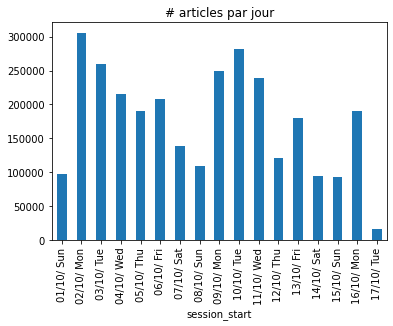

In [19]:
# Plot month_day distribution
clicks.groupby(clicks['session_start'].dt.strftime('%d/%m/ %a')).size().plot(kind='bar', title='# articles par jour')

***Observations:***
- Les utilisateurs consultent plus les articles en début de semaine, plutôt que le weekend.

### **Contexte de consultation des articles**

---

- <code>click_environment</code> : l'identifiant de l'environnement (1-Facebook, 2-Appli mobile 3-Pages mobiles 4- Web) ;
- <code>click_deviceGroup</code> : le type de terminal utilisé (1-tablette, 2-TV, 4-Mobile, 5-Ordinateur, ou 3-vide) ;
- <code>click_os</code> : l'identifiant du système d'exploitation (1-Other, 2-iOS, 3-Android, 4-Windows Phone, 5-Windows Mobile, 6-Windows, 7-Mac OS X, 8-Mac OS, 9-Samsung, 10-FireHbbTV, 11-ATV OS X, 12-tvOS, 13-Chrome OS, 14-Debian, 15-Symbian OS, 16-BlackBerry OS, 17-Firefox OS, 18-Android, 19-Brew MP, 20-Chromecast, 21-webOS, 22-Gentoo, 23-Solaris) ;

<function matplotlib.pyplot.show>

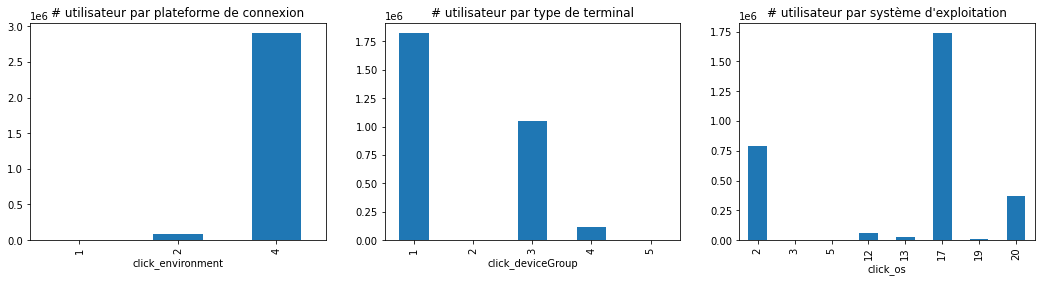

In [20]:
a = clicks.groupby('click_environment')['user_id'].count()
b = clicks.groupby('click_deviceGroup')['user_id'].count()
c = clicks.groupby('click_os')['user_id'].count()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
a.plot(kind='bar', title='# utilisateur par plateforme de connexion', ax=ax1)
b.plot(kind='bar', title='# utilisateur par type de terminal', ax=ax2)
c.plot(kind='bar', title='# utilisateur par système d\'exploitation', ax=ax3)
plt.show

***Observations***:
- La lecture d'article se fait sur la page Web de Globo.com (peu de consultation sur l'application mobile) ;
- Les utilisateurs consultent majoritairement les articles sur tablette ;
- L'OS majortaire est Firefox.

**NOTE**: ces données apporteraient du **biais** dans notre projet car notre **MVP** (produit viable minimum) est une **application mobile** : elles ne seront donc pas prise en compte dans notre système de recommandation.

## <font color=blue>**Profilage des articles**</font>

### **Analyse des catégories**

In [21]:
# Merge DF
clicks_articles = pd.merge(clicks, articles, how='inner', on='article_id')

# Convert timestamp to datetime
clicks_articles['session_start'] = pd.to_datetime(clicks_articles['session_start'].dt.strftime('%Y/%m/%d'))
clicks_articles['click_timestamp'] = pd.to_datetime(clicks_articles['click_timestamp'].dt.strftime('%Y/%m/%d'))

# Display shape and 5 first rows
print(clicks_articles.shape)
clicks_articles.head()

(2988181, 17)


,user_id,session_id,session_start,session_size,article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,filename,category_id,created_at_ts,publisher_id,words_count
0,0,1506825423271737,2017-10-01,2,157541,2017-10-01,4,3,20,1,20,2,0,281,2017-09-30,0,280
1,20,1506825727279757,2017-10-01,2,157541,2017-10-01,4,1,17,1,9,1,0,281,2017-09-30,0,280
2,44,1506826139185781,2017-10-01,5,157541,2017-10-01,4,1,17,1,12,1,0,281,2017-09-30,0,280
3,45,1506826142324782,2017-10-01,2,157541,2017-10-01,4,1,17,1,17,1,0,281,2017-09-30,0,280
4,76,1506826463226813,2017-10-01,2,157541,2017-10-01,4,3,2,1,21,1,0,281,2017-09-30,0,280


<function matplotlib.pyplot.show>

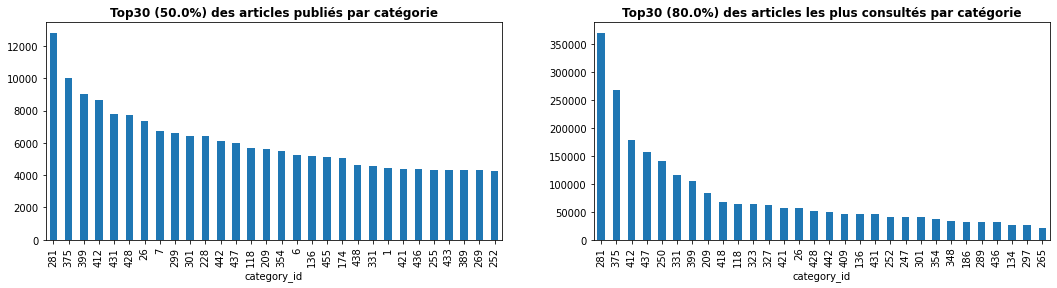

In [22]:
# Plot nb articles per categorie
d = articles.groupby('category_id')['article_id'].nunique().sort_values(ascending=False)
e = clicks_articles.groupby('category_id')['article_id'].count().sort_values(ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 4))
d.head(30).plot(kind='bar', ax=ax1)
ax1.set_title('Top30 ({}%) des articles publiés par catégorie'.format(
    round(sum(d.head(30))/sum(d) * 100, 0)),
    fontsize=12, fontweight='bold')
e.head(30).plot(kind='bar', ax=ax2)
ax2.set_title('Top30 ({}%) des articles les plus consultés par catégorie'.format(
    round(sum(e.head(30))/sum(e) * 100, 0)),
    fontsize=12, fontweight='bold')
plt.show

In [23]:
# Find intersection (lst1 order)
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

print(intersection(d.head(30).index.to_list(), e.head(30).index.to_list()))

[281, 375, 399, 412, 431, 428, 26, 301, 442, 437, 118, 209, 354, 136, 331, 421, 436, 252]


In [24]:
# Print 5 first rows
d.head()

category_id
281    12817
375    10005
399     9049
412     8648
431     7759
Name: article_id, dtype: int64

In [25]:
# Print 5 first rows
e.head()

category_id
281    370843
375    268257
412    178894
437    157085
250    140454
Name: article_id, dtype: int64

***Observations:***
- 50% des articles publiés appartiennent au top 30 des catégories (461 au total) ;
- Les catégories **281, 375 et 412** concentrent à la fois un grand nombre d'articles publiés (31.340; 68% des articles) et un grand nombre d'articles consultés (817.994, 27% des interactions) : probablement des sujets d'actualité (politique, économie, etc.).

**NOTE**: Utiliser la catégorie risque de cantonner nos recommendations sur les articles populaires.

### **Analyse du nombre de mots**

# mots par article, Mean: 191.0 - Min: 0, Max: 6690.
La moitié des articles comprennent entre 159.0 et 218.0 mots


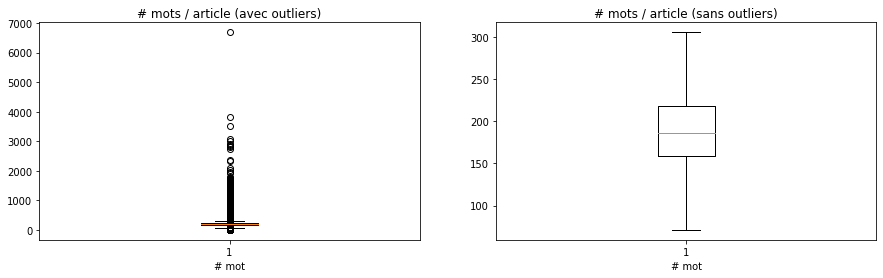

In [26]:
# Print information
x = articles['words_count']
print(
    '# mots par article, Mean: {} - Min: {}, Max: {}.'.format(round(x.mean(), 0),
                                                              x.min(),
                                                              x.max()))
print('La moitié des articles comprennent entre {} et {} mots'.format(x.quantile(.25),
                                                                      x.quantile(.75)))

# Plot boxplot
fig, (ax1, ax2) = plt.subplots (1, 2, figsize=(15, 4))
ax1.boxplot(x)
ax1.set_xlabel('# mot')
ax1.set_title('# mots / article (avec outliers)')
ax2.boxplot(x, showfliers=False)
ax2.set_xlabel('# mot')
ax2.set_title('# mots / article (sans outliers)')
plt.show()

Etonnamment, nous avons des articles SANS mots !

In [27]:
# Focus on articles without words_count
print('Nb d\'articles concernés: ', len(articles[articles['words_count'] == 0]))
articles[articles['words_count'] == 0]

Nb d'articles concernés:  35


,article_id,category_id,created_at_ts,publisher_id,words_count
35491,35491,43,2016-08-04,0,0
38472,38472,51,2011-04-21,0,0
39043,39043,64,2014-06-30,0,0
39054,39054,64,2015-01-21,0,0
164414,164414,288,2015-03-30,0,0
206233,206233,331,2017-09-30,0,0
212323,212323,343,2010-04-19,0,0
212324,212324,343,2010-04-16,0,0
212327,212327,343,2014-08-11,0,0
212526,212526,347,2018-01-28,0,0


***Observations***:
- Les articles font en moyenne **~200 mots**;
- Nous avons quelques légères incohérences avec des **articles sans mots**, majoritairement dans la catégorie **431**.

### **Chronologie de consultation**

In [28]:
# Calculate view recency
clicks_articles['view_recency'] = clicks_articles['click_timestamp'] - clicks_articles['created_at_ts']
clicks_articles['view_recency'] = (clicks_articles['view_recency'] / pd.Timedelta(days=1))

# Filter article by popularity
articles_popularity = clicks_articles.groupby('article_id', as_index=False)['click_timestamp'].count()
articles_popularity.rename(columns={'click_timestamp':'nbClicks'}, inplace=True)
articles_popularity.sort_values(by=['nbClicks'], ascending=False, inplace=True)

# Keep only the top 10 articles for analysis
articles_top10 = articles_popularity.head(10)

# Merge the top10 with 1st DF to track creation and start session date
articles_top10 = pd.merge(articles_top10, clicks_articles, on='article_id')

# Ensure there is no inconsistent data
articles_top10 = articles_top10[articles_top10.view_recency >= 0]
print('Top10 articles interactions shape: ', articles_top10.shape)

# Create DF with only the top10 articles
top10_clicks_per_day = pd.DataFrame(
    articles_top10.groupby(['article_id','view_recency'], as_index=False)['click_timestamp'].count())

# Display shape and 5 first rows
print('Top10 articles views shape: ', top10_clicks_per_day.shape)
top10_clicks_per_day.head()

Top10 articles interactions shape:  (240861, 19)
Top10 articles views shape:  (94, 3)


,article_id,view_recency,click_timestamp
0,96210,0.0,1252
1,96210,1.0,17613
2,96210,2.0,2663
3,96210,3.0,34
4,96210,4.0,12


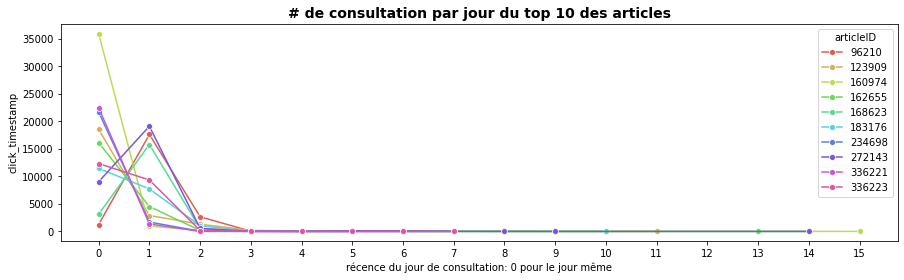

In [29]:
# Plot articles view per 1st day to 15th day
plt.figure(figsize=(15, 4))
palette = sns.color_palette('hls', 10)
sns.lineplot(x=top10_clicks_per_day['view_recency'],
             y=top10_clicks_per_day['click_timestamp'],
             hue=top10_clicks_per_day['article_id'],
             data=top10_clicks_per_day,
             palette=palette,
             marker='o')
plt.xticks(range(0, len(top10_clicks_per_day.view_recency.unique())+1))
plt.xlabel('récence du jour de consultation: 0 pour le jour même')
plt.legend(top10_clicks_per_day.article_id.unique(), title='articleID')
plt.title('# de consultation par jour du top 10 des articles',
          fontsize=14, fontweight='bold')
plt.show()

***Observations***:
- Sur le top10, les articles sont consultés soit le jour même soit le lendemain, et l'intérêt décroît très vite sur les jours suivants.

# <font color=green>**Synthèse**</font>

---

Ici, nous **avons exclusivement des données implicites**: les données sont binaires (article lu / non lu par l'utilisateur, sans scores ou ratings).

- **Avantage** : elles sont faciles à collecter ;
- **Inconvénient** : elles ne donnent pas d'indication sur le fait que l'utilisateur n'apprécie pas un article ou que l'article consulté le concerne lui-même ou concerne une tierce personne.

Nous n'avons pas pu créer des **données exploitables** additionnelles telles que :
- La durée de consultation : celle-ci aurait peut-être permis de créer artificiellement un rating sur l'intérêt porté à l'article